In [1]:
from ipywidgets import IntSlider
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
import pandas as pd
import scipy
import shap
import numpy as np
import ZCA as zca
import statsmodels.api as sm
import matplotlib as plt

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import sklearn
from sklearn.preprocessing import *
from sklearn import preprocessing
import matplotlib.pyplot as plt

import IPython

import os
os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'
import rpy2.robjects as R
from rpy2.robjects import pandas2ri
pandas2ri.activate()

from numpy import mean
from numpy import arange
from numpy import std
from numpy import absolute
from pandas import read_csv
import matplotlib.pyplot
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from sklearn.linear_model import ElasticNet
import seaborn as sns
from ModelDiagnostics import Plot
from sklearn.cluster import DBSCAN
from clustergram import Clustergram
import urbangrammar_graphics as ugg
from sklearn.preprocessing import scale
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from scipy.stats import f

import dtale
from pandas_profiling import ProfileReport

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
#power = PowerTransformer(method='box-cox')

def testNormal (x):    
    
    k2, p = stats.normaltest(x)
    alpha = .001
    #print("p = {:g}".format(p))    
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        #print(p)
        #print(alpha)
        print("The null hypothesis can be rejected")
        xt, _ = stats.yeojohnson(x)
        #xt, _ = stats.boxcox(x)        
        print(_)
        xt = pd.DataFrame(xt)
        
        return _, pd.DataFrame(xt).set_index(x.index)
    else:
        print("The null hypothesis cannot be rejected")    
        return 1, pd.DataFrame(x)

def inverse_boxcox (data, lambdas):
    return inv_boxcox(data, lambdas.values)
    
def transform_boxcox_l(data, l_):
    transformed = pd.DataFrame()

    for i in range(0,len(data.columns)):
        #print(i)
        if l_.iloc[i].values == 1:
            inner_scale = data.iloc[:,i]            
        else:
            inner_scale = pd.DataFrame(stats.boxcox((data.iloc[:,i]), lmbda=l_.iloc[i].values))
            
        inner_scale.index = data.index
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed

def transform_boxcox (data):
    transformed = pd.DataFrame()
    transformed_lambdas = pd.DataFrame()

    for i in range(0,len(data.columns)):
        l, inner_scale = testNormal(data.iloc[:,i])
        inner_scale.set_index(data.index)

        transformed_lambdas = pd.concat([transformed_lambdas,pd.DataFrame(pd.Series(l))],axis=0)
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed, transformed_lambdas

def revert_boxcox (data, lambdas):
    reverted = pd.DataFrame()

    for i in range(0,len(data.columns)):        
        if lambdas.iloc[i].values == 1 :
            revert = data.iloc[:,i]
        else:
            revert = pd.DataFrame(inv_boxcox(data.iloc[:,i].values, lambdas.iloc[i].values))            
        revert.index = data.index
        reverted = pd.concat([reverted,revert],axis=1)
        
    reverted.columns = data.columns
    return reverted


In [4]:

all_data = pd.read_csv('/mnt/distvol/combined_set.csv')
all_data.index = all_data.iloc[:,0]
all_data = all_data.iloc[:,1:]



In [5]:
all_data.columns

Index(['DGS10', 'DTB3', 'DGS3MO', 'MORTGAGE30US', 'DFII10', 'T5YIFR',
       'BAMLHYH0A0HYM2TRIV', 'BAMLCC0A1AAATRIV', 'DGS1', 'BAMLCC0A4BBBTRIV',
       'IC4WSA', 'WILLMICROCAPPR', 'WILLLRGCAPVAL', 'T5YIE', 'WTB3MS',
       'WGS3MO', 'TWEXB', 'DEXCHUS', 'DEXUSUK', 'TEDRATE', 'VIXCLS', 'NFCI',
       'BAA10Y', 'BAMLC0A0CM', 'BAMLH0A3HYC', 'DCOILBRENTEU', 'DCOILWTICO',
       'DFF', 'DGS1MO', 'DGS30', 'DGS5', 'ICSA', 'M1', 'STLFSI2', 'T10Y2Y',
       'T10Y3M', 'TREAST', '^SP500TR', 'QQQ', 'DIA', 'IYR', 'EWG', 'EWU',
       'EWJ', 'EZU', 'EWZ', 'ILF', 'EWW', 'LQD', 'SHY', 'IEF', 'TLT', 'ETH',
       'BCH', 'LTC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK',
       'XLU', 'MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO',
       'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT',
       'NKE', 'PG', 'TRV', 'UNH', 'VZ', 'WMT', 'WBA', 'DIS'],
      dtype='object')

In [6]:
R.r('''
           f <- function(values) {
                    #system("which openssl")

                    library(snpEnrichment)
                    library(arfima)
                    library(parallel)
                    library(forecast)                    
                    
                    dset <- lapply(1:ncol(values),function(x)
                    {
                        column = values[,x]
                        
                        
                        #tryCatch(invisible(capture.output(suppressMessages(suppressWarnings(
                        #{
                          varvefd = arfima(column)
                          d = summary(varvefd)$coef[[1]][1]
                          return(d)
                        #}
                       #)
                       #))),
                        #error=function(e)
                          #{
                            #d = 1
                            #return(d)
                          #})
                    
                    })    
                    
                    unlist(dset)

            }
            ''')

r_f = R.globalenv['f']
d=R.conversion.rpy2py((r_f(R.conversion.py2rpy(all_data.dropna()))))


R[write to console]: Loading required package: ltsa

R[write to console]: Note that the arfima package has new defaults starting with
1.4-0: type arfimachanges() for a list, as well as some other notes.
NOTE: some of these are quite important!

R[write to console]: 
Attaching package: ‘arfima’


R[write to console]: The following object is masked from ‘package:stats’:

    BIC


R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: 
Attaching package: ‘forecast’


R[write to console]: The following object is masked from ‘package:arfima’:

    arfima


R[write to console]: Error in stats::arima(x = x, order = order, seasonal = seasonal, include.mean = include.mean,  : 
  non-stationary AR part from CSS

R[write to console]: Error in stats::arima(x = x, order = order, seasonal = seasonal, include.mean = include.mean,  : 
  non-stationary AR part from CSS

R[write to console]: Error in stats::arima(x = 

In [7]:
d

array([2.71776596e-01, 1.29709976e-01, 1.83542206e-01, 2.19398733e-01,
       9.32186792e-02, 4.58301292e-05, 4.97179539e-01, 4.80563313e-01,
       1.43365136e-01, 4.66944216e-01, 7.32402798e-05, 4.58301292e-05,
       4.96827793e-01, 4.58301292e-05, 1.15909458e-01, 1.18399093e-01,
       4.58301292e-05, 3.83916321e-02, 4.58301292e-05, 4.58301292e-05,
       4.58301292e-05, 4.58301292e-05, 4.58301292e-05, 4.58301292e-05,
       4.58301292e-05, 4.58301292e-05, 4.58301292e-05, 1.32427863e-02,
       2.38011173e-01, 8.21846395e-02, 4.58301292e-05, 4.58301292e-05,
       4.93862264e-01, 1.74975036e-03, 1.15258054e-01, 1.60185172e-01,
       4.95793469e-01, 4.96868956e-01, 4.64181871e-01, 4.96994998e-01,
       4.58301292e-05, 4.58301292e-05, 3.19912577e-02, 4.58301292e-05,
       5.28241213e-02, 4.58301292e-05, 4.58301292e-05, 1.21312196e-02,
       4.90565014e-01, 7.05382141e-02, 4.97176357e-01, 3.12804721e-02,
       4.58301292e-05, 4.58301292e-05, 4.58301292e-05, 4.96852289e-01,
      

In [8]:
d_ = dtale.show(all_data)
d_.open_browser()
d_._url  

'http://slurmw01:40000'

In [9]:
def get_weights(d, num_k):
    r"""Calculate weights ($w$) for each lag ($k$) through
    $w_k = -w_{k-1} \frac{d - k + 1}{k}$.
    
    Args:
        d (int): differencing value.
        num_k (int): number of lags (typically length of timeseries) to calculate w.
    """
    w_k = np.array([1])
    
    for k in range(1, num_k):
        w_k = np.append(w_k, -w_k[-1] * ((d - k + 1)) / k)
        
    w_k = w_k.reshape(-1, 1) 
    
    return w_k

def get_weights_floored(d, num_k, floor=1e-3):
    r"""Calculate weights ($w$) for each lag ($k$) through
    $w_k = -w_{k-1} \frac{d - k + 1}{k}$ provided weight above a minimum value
    (floor) for the weights to prevent computation of weights for the entire
    time series.
    
    Args:
        d (int): differencing value.
        num_k (int): number of lags (typically length of timeseries) to calculate w.
        floor (float): minimum value for the weights for computational efficiency.
    """
    w_k = np.array([1])
    k = 1
    
    while k < num_k:
        w_k_latest = -w_k[-1] * ((d - k + 1)) / k
        if abs(w_k_latest) <= floor:
            break

        w_k = np.append(w_k, w_k_latest)
        
        k += 1

    w_k = w_k.reshape(-1, 1) 
    
    return w_k

def frac_diff(df, d, floor=1e-3):
    r"""Fractionally difference time series via CPU.
    
    Args:
        df (pd.DataFrame): dataframe of raw time series values.
        d (float): differencing value from 0 to 1 where > 1 has no FD.
        floor (float): minimum value of weights, ignoring anything smaller.
    """
    # Get weights window
    weights = get_weights_floored(d=d, num_k=len(df), floor=floor)
    weights_window_size = len(weights)
    
    # Reverse weights
    weights = weights[::-1]
    
    # Blank fractionally differenced series to be filled
    df_fd = []

    # Slide window of time series, to calculated fractionally differenced values
    # per window
    for idx in range(weights_window_size, df.shape[0]):
        # Dot product of weights and original values
        # to get fractionally differenced values
        date_idx = df.index[idx]
        df_fd.append(np.dot(weights.T, df.iloc[idx - weights_window_size:idx]).item())
    
    # Return FD values and weights
    df_fd = pd.DataFrame(df_fd)
    
    return df_fd, weights

In [10]:
import concurrent.futures
from concurrent.futures import wait, ALL_COMPLETED
from fracdiff import fdiff

cores = int(len(os.sched_getaffinity(0)))

def getDifferenced(i):
    #v = d[[i]]
    #gquant_gpu, weights = frac_diff(all_data.iloc[:, i], d=d[[i]], floor=5e-5)
    
    a = np.array(all_data.iloc[:, i])
    
    return fdiff(a, n=d[i], axis=0)
    #gquant_gpu, weights = frac_diff(all_data.iloc[:, i]), d=v, floor=5e-5)

pool01 = concurrent.futures.ProcessPoolExecutor(cores)

futures01 = [pool01.submit(getDifferenced, args) for args in range(0,len(d))]

wait(futures01, timeout=None, return_when=ALL_COMPLETED)


DoneAndNotDoneFutures(done={<Future at 0x7f8a9abd8070 state=finished returned ndarray>, <Future at 0x7f8a9abdc070 state=finished returned ndarray>, <Future at 0x7f8a9abd0130 state=finished returned ndarray>, <Future at 0x7f8a9abd8190 state=finished returned ndarray>, <Future at 0x7f8a9abdc190 state=finished returned ndarray>, <Future at 0x7f8a9ac2a1c0 state=finished returned ndarray>, <Future at 0x7f8a9abd0250 state=finished returned ndarray>, <Future at 0x7f8a9abd82b0 state=finished returned ndarray>, <Future at 0x7f8a9abdc2b0 state=finished returned ndarray>, <Future at 0x7f8a9abd0370 state=finished returned ndarray>, <Future at 0x7f8a9abd83d0 state=finished returned ndarray>, <Future at 0x7f8a9abdc3d0 state=finished returned ndarray>, <Future at 0x7f8a9abd0490 state=finished returned ndarray>, <Future at 0x7f8a9abd84f0 state=finished returned ndarray>, <Future at 0x7f8a9abdc4f0 state=finished returned ndarray>, <Future at 0x7f8a9abcbfd0 state=finished returned ndarray>, <Future at 0

Process ForkProcess-4:
Process ForkProcess-1:
Process ForkProcess-3:
Process ForkProcess-2:
Traceback (most recent call last):
  File "/mnt/distvol/Python-3.9.4/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/mnt/distvol/Python-3.9.4/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/distvol/Python-3.9.4/lib/python3.9/concurrent/futures/process.py", line 237, in _process_worker
    call_item = call_queue.get(block=True)
  File "/mnt/distvol/Python-3.9.4/lib/python3.9/multiprocessing/queues.py", line 102, in get
    with self._rlock:
  File "/mnt/distvol/Python-3.9.4/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/mnt/distvol/Python-3.9.4/lib/python3.9/multiprocessing/process.py", line 315, 

In [11]:
Differenced_Set = pd.DataFrame()
for f in range(0,len(futures01)):
    value = pd.DataFrame(futures01[f].result())
    Differenced_Set = pd.concat([Differenced_Set,value],axis=1)
    
Differenced_Set.columns = all_data.columns

In [14]:
if False:
    for f in range(0,len(futures01)):
        #print(f)
        #print(len(futures01[f].result()))
        plt.hist(Differenced_Set.iloc[:,f], bins='auto')  # arguments are passed to np.histogram
        plt.show()
        Differenced_Set.iloc[:,1].plot()
        plt.show()
        plt.hist(all_data.iloc[:,f], bins='auto')  # arguments are passed to np.histogram
        plt.show()
        all_data.iloc[:,1].plot()
        plt.show()    



In [15]:
c = all_data.corr()
#.abs()
s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)

In [16]:
filter_ = all_data.columns.tolist()

In [17]:
output_slider_variable = widgets.Text()

def f2(x):    
    output_slider_variable.value = str(x)
    
def f3(x):
    Y = output_slider_variable.value    
    internalFilter = filter_
    internalFilter.remove(Y)
    all_data_ = pd.concat([all_data[Y],all_data[internalFilter]], axis=1)    
    print(all_data_.describe())
    
output_slider_variable.observe(f3, 'value')

print("choose Y")
interact(f2, x=filter_);

#dir(output_text.widget.out)

choose Y


interactive(children=(Dropdown(description='x', options=('DGS10', 'DTB3', 'DGS3MO', 'MORTGAGE30US', 'DFII10', …

In [186]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

set_ = Differenced_Set
set_.index = all_data.index

Lagged_Differenced_Set = pd.DataFrame()
Lagged_Set = pd.DataFrame()
#TrainO_Lagged_Set = pd.DataFrame()
lags = []
lagcorrs = []
ogcorrs = []

def critical_r(n, alpha = .05 ):
    df = n - 2
    critical_t = scipy.stats.t.isf(alpha / 2, df)
    critical_r = np.sqrt( (critical.t^2) / ( (critical.t^2) + df ) )
    return(critical_r)

def xcorr(x, y, maxlags=10):
    Nx = len(x)
    if Nx != len(y):
        raise ValueError('x and y must be equal length')

    c = np.correlate(x, y, mode=2)

    if maxlags is None:
        maxlags = Nx - 1

    if maxlags >= Nx or maxlags < 1:
        raise ValueError('maxlags must be None or strictly positive < %d' % Nx)

    c = c[Nx - 1 - maxlags:Nx + maxlags]

    return c

maxl = 5

for f in range(1,len(set_.columns)):
    #print(f)
    #print(len(futures01[f].result()))
        
    data_1 = set_.iloc[:,0]
    data_2 = set_.iloc[:,f]

    ogc = np.array(pd.concat([data_1 - np.mean(data_1),data_2 - np.mean(data_2)],axis=1).corr())[1,0]    
    ogcorrs.append(ogc)
    
    #corr = xcorr(data_1 - np.mean(data_1), data_2 - np.mean(data_2),maxlags=5)

    set1 = data_1 - np.mean(data_1)
    set2 = data_2 - np.mean(data_2)
    
    corrs_ = []
    for i in range(0,maxl):
        c = np.array((pd.concat([set1,set2.shift(i)],axis=1).dropna()).corr())[0,1]
        corrs_.append(c)
        
    #corr = np.correlate(data_1 - np.mean(data_1), data_2 - np.mean(data_2),mode='full')
    #plt.plot(corr)
    #plt.show()
    
    #lag = corr.argmax() - (len(data_1) - 1)
    lag = abs(pd.Series(corrs_)).idxmax()
    
    #print(corr)
    lagc = np.array(pd.concat([data_1 - np.mean(data_1),(data_2 - np.mean(data_2)).shift(lag)],axis=1).corr())[1,0]
    
    #print(lag)

    #print(ogc)
    #print(lagc)
    
    #print(lag)
    #plt.plot(data_1, 'r*')
    #plt.plot(data_2, 'b*')
    
    lag_merged = pd.concat([data_1 - np.mean(data_1),(data_2 - np.mean(data_2)).shift(lag)],axis=1)
    
    x_ticks = all_data.index[np.arange(0, len(all_data.index), 5)]
    #plt.xticks(x_ticks, rotation = 45)    
    #plt.show()

    #plt.scatter(data_2.shift(lag),data_1)
    #plt.show()
    
    #plot_acf(data_2.shift(lag))
    #plt.show()
    
    #plot_pacf(data_2.shift(lag))
    #plt.show()

    y = data_1
    X = data_2
    #reg = LinearRegression().fit(X, y)

    #print(reg.score(X, y),reg.coef_,reg.intercept_)

    model = sm.OLS(y,X)
    results = model.fit()
    #print(results.summary())
    
    Lagged_Differenced_Set = pd.concat([Lagged_Differenced_Set,data_2.shift(lag)],axis=1)
    #TrainO_Lagged_Set = pd.concat([TrainO_Lagged_Set,all_data.iloc[:,f].shift(lag)],axis=1)
    #if lag>0:
        #lag = 0
    
    Lagged_Set = pd.concat([Lagged_Set,all_data.iloc[:,f].shift(lag)],axis=1)
    
    lagcorrs.append(lagc)
    
    lags.append(lag)

In [187]:
Lagged_Set = pd.concat([all_data.iloc[:,0],Lagged_Set],axis=1)
Lagged_Differenced_Set = pd.concat([all_data.iloc[:,0],Lagged_Differenced_Set],axis=1)

In [188]:
#Lagged_Set
#lags
pd.concat([pd.DataFrame(all_data.columns[1:]),pd.DataFrame(lags),pd.DataFrame(lagcorrs),pd.DataFrame(ogcorrs)],axis=1)

,0,0,0,0
0,DTB3,0,0.541888,0.541888
1,DGS3MO,0,0.557480,0.557480
2,MORTGAGE30US,0,0.954669,0.954669
3,DFII10,0,0.842971,0.842971
4,T5YIFR,0,0.506653,0.506653
...,...,...,...,...
85,UNH,0,-0.422312,-0.422312
86,VZ,4,-0.507730,-0.348276
87,WMT,2,-0.347307,-0.299259
88,WBA,3,-0.348420,-0.248605


In [189]:
Lagged_Differenced_Set
#from fracdiff import FracdiffStat
#fs = FracdiffStat(window=100, mode="valid")
#diff = fs.fit_transform(nky.values.reshape(-1, 1))

,DGS10,DTB3,DGS3MO,MORTGAGE30US,DFII10,T5YIFR,BAMLHYH0A0HYM2TRIV,BAMLCC0A1AAATRIV,DGS1,BAMLCC0A4BBBTRIV,...,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WMT,WBA,DIS
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2003-09-30,4.227656,0.928281,0.947812,6.033846,2.203906,2.268125,NaN,NaN,1.219219,NaN,...,NaN,NaN,NaN,NaN,NaN,21.319325,NaN,NaN,NaN,NaN
2003-12-31,4.285161,0.795238,0.761198,4.595468,1.805361,2.537315,NaN,NaN,1.121658,NaN,...,NaN,NaN,NaN,NaN,NaN,11.655751,NaN,NaN,NaN,NaN
2004-03-31,4.010000,0.744966,0.691051,3.782129,1.411828,2.458380,NaN,347.606716,0.960719,NaN,...,NaN,NaN,NaN,27.368460,NaN,11.745792,NaN,39.559052,NaN,NaN
2004-06-30,4.597097,0.875694,0.811685,4.064521,1.743691,2.633988,NaN,185.500844,1.474427,NaN,...,NaN,NaN,NaN,29.681616,NaN,10.046094,NaN,19.764847,22.193444,NaN
2004-09-30,4.301406,1.240973,1.170057,3.561250,1.534489,2.481008,417.532687,149.876881,1.663095,353.016269,...,27.587086,17.275098,5.572157,31.455443,22.987969,8.841159,13.911913,15.935334,22.580906,16.798414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31,1.365000,0.491868,0.307194,1.618877,-0.158119,1.572655,269.670613,187.391437,0.404244,190.371180,...,60.118647,27.529818,23.414552,113.028189,27.166114,68.514844,12.222250,33.731630,30.372063,22.190481
2020-06-30,0.687619,-0.362118,-0.532349,1.400303,-0.540136,1.482939,297.524751,172.217585,-0.388200,216.681383,...,61.499123,42.817094,20.954814,117.781530,41.974289,70.999950,12.625856,33.667952,33.070866,42.485933
2020-09-30,0.650625,-0.226975,-0.327824,1.211842,-0.940988,1.715246,297.623273,178.962768,-0.247752,239.217270,...,64.891265,43.653843,20.476031,116.199859,39.002418,83.513280,11.953796,25.499680,38.095149,38.373307


In [190]:
transformed, lambdas = transform_boxcox(Lagged_Differenced_Set.dropna())

The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis can be rejected
-0.7837342612075002
The null hypothesis cannot be rejected
The null hypothesis can be rejected
0.4614618463819046
The null hypothesis can be rejected
-8.971378904843366
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis can be rejected
2.2373739940524824
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis can be rejected
-8.971378904843366
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis can be rejected
-4.410264984947239
The null hypothesis can be rejected
-1.3061274028958025
The null hypothesis can be rejected
-1.7936617897970866
The null hy

In [135]:
#Difference (only if not using differenced)
#transformed = (transformed - transformed.shift(-1)).dropna()

,DGS10,DTB3,DGS3MO,MORTGAGE30US,DFII10,T5YIFR,BAMLHYH0A0HYM2TRIV,BAMLCC0A1AAATRIV,DGS1,BAMLCC0A4BBBTRIV,...,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WMT,WBA,DIS
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2004-09-30,4.301406,1.240973,1.170057,3.561250,1.534489,2.481008,417.532687,1.250918,1.663095,30.352272,...,27.587086,3.773514,5.572157,1.326830,22.987969,8.841159,13.911913,2.454365,22.580906,16.798414
2004-12-31,4.175806,1.684174,1.592081,3.265256,1.309160,2.410222,233.867655,1.245106,1.959107,22.706407,...,21.401864,2.820407,3.797042,1.331890,13.396768,13.162466,6.067687,2.301923,20.663383,9.643745
2005-03-31,4.303607,2.104959,1.979052,3.210545,1.333929,2.453002,190.228973,1.244520,2.442115,20.612820,...,21.610158,2.424366,3.450437,1.333790,12.736108,14.034077,6.664125,2.068979,19.760940,9.305043
2005-06-30,4.158594,2.298853,2.137906,3.054770,1.281342,2.388926,146.013410,1.242847,2.553155,17.942004,...,21.251378,2.197945,2.541826,1.333338,9.849975,14.126242,4.749367,2.112903,20.895795,6.169089
2005-09-30,4.215156,2.681254,2.492514,3.041456,1.417925,2.339072,142.546125,1.240156,2.882623,17.781574,...,19.960261,2.242216,2.413771,1.333199,4.958140,13.760587,5.102193,1.982089,21.052125,4.487760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31,1.365000,0.491868,0.307194,1.618877,-0.158119,1.572655,269.670613,1.254915,0.404244,22.315891,...,60.118647,4.538257,23.414552,1.404859,27.166114,68.514844,12.222250,2.971643,30.372063,22.190481
2020-06-30,0.687619,-0.362118,-0.532349,1.400303,-0.540136,1.482939,297.524751,1.253485,-0.388200,23.815389,...,61.499123,5.332727,20.954814,1.406437,41.974289,70.999950,12.625856,2.970370,33.070866,42.485933
2020-09-30,0.650625,-0.226975,-0.327824,1.211842,-0.940988,1.715246,297.623273,1.254147,-0.247752,25.023788,...,64.891265,5.369126,20.476031,1.405924,39.002418,83.513280,11.953796,2.781296,38.095149,38.373307


In [191]:
cbd = True
ic = True

# evaluate an elastic net model on the dataset
tsize = .20
train, test = train_test_split(transformed.iloc[:,0:], test_size=tsize, shuffle=False)

interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=ic)

#train_t, lambdas_t = transform_boxcox(train)

#disabled boxcox
if cbd:
    train_t = train

scaler = preprocessing.StandardScaler().fit(train_t)

#
train_s = pd.DataFrame(scaler.transform(train_t))
train_s.columns = train.columns
train_s.index = train.index  

train_t = train_s

#test_t = transform_boxcox_l(test, lambdas_t)

#disabled boxcox
if cbd:
    test_t = test

test_s = pd.DataFrame(scaler.transform(test_t))
test_s.columns = test.columns
test_s.index = test.index

test_t = test_s

y_train = pd.DataFrame(train_t.iloc[:,0])

#exclude y

X_inter_train = pd.DataFrame(interaction.fit_transform(train_t.iloc[:,1:]), columns=interaction.get_feature_names(input_features=pd.DataFrame(train_t.iloc[:,1:]).columns))

    #apply ZCA each time a set of factors are removed (i.e. iteratively)
 #trf = zca.ZCA().fit(X_inter_train)
  #trf = zca.ZCA().fit(X_train)

 #X_train = pd.DataFrame(trf.transform(X_inter_train))
  #X_train = pd.DataFrame(trf.transform(X_train))
 #X_train.columns=X_inter_train.columns
  #X_train.columns=X_train.columns
  #X_train.index = train.index

#X_inter_alt = X_train.iloc[:, np.array(range(0,len(all_data.iloc[:,2:].columns)))]
#print(X_inter_alt.head(3))

y_test = pd.DataFrame(test_t.iloc[:,0])

X_inter_test = pd.DataFrame(interaction.fit_transform(test_t.iloc[:,1:]), columns=interaction.get_feature_names(input_features=pd.DataFrame(test_t.iloc[:,1:]).columns))

 #X_test = pd.DataFrame(trf.transform(X_inter_test))
  #X_test = pd.DataFrame(trf.transform(X_test))

 #X_test.columns=X_inter_test.columns
  #X_test.columns=X_test.columns
  #X_test.index = test.index

#X_inter_t_alt = X_test.iloc[:, np.array(range(0,len(all_data.iloc[:,2:].columns)))]
#X_inter_t_alt.head()


In [192]:
# define model evaluation method
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
ratios = arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]

 #model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=4, verbose=0, precompute='auto')

model = ElasticNet()
grid = dict()
# fit model

grid['alpha'] = alphas
grid['l1_ratio'] = ratios

#search = HalvingRandomSearchCV(model, grid,resource='n_samples',max_resources=10,random_state=0)

search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

 #results = search.fit(X_inter_train, y_train)
#results = search.fit(X_train, y_train)

results = search.fit(X_inter_train, y_train)

 #model.fit(X_inter_train, y_train)
# summarize chosen configuration

print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

print(results.best_estimator_)
best_model = ElasticNet(alpha=results.best_estimator_.alpha, l1_ratio = results.best_estimator_.l1_ratio)

#pd.concat([all_data[Y],all_data_int],axis=1)



MAE: -0.040
Config: {'alpha': 0.01, 'l1_ratio': 0.48}
ElasticNet(alpha=0.01, l1_ratio=0.48)


In [193]:
best_model.fit(X_inter_train,train_t.iloc[:,0])

trainScore = best_model.score(X_inter_train, y_train, sample_weight=None)
testScore = best_model.score(X_inter_test, y_test, sample_weight=None)
print(trainScore)
print(testScore)


0.9996178407296584
0.9972717541637722


In [315]:
# multivariate output multi-step 1d cnn example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.optimizers import SGD
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    
    return array(X), array(y)

#n_steps_in = int(np.floor(len(train)*.8))
n_steps_in = 48
print(n_steps_in)
#n_steps_out = int(len(train)-n_steps_in)
n_steps_out = 1
print(n_steps_out)

X, y = split_sequences(np.array(transformed), n_steps_in, n_steps_out)

#for i in range(len(X)):
#    print(X[i], y[i])
    
#flatten output
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))

n_features = X.shape[2]

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_output))

# fit model
#model.fit(X, y, epochs=7000, verbose=0)

epochs_ = 200
batch_size_ = 25

#np.random.seed(42)
#tf.random.set_seed(42)

#simple RNN
#data_ = Lagged_Set
'''
model6 = keras.models.Sequential([
    keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[None, len(data_.columns)]),
    keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[None, len(data_.columns)]),
    keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[None, len(data_.columns)]),
    keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[None, len(data_.columns)]),
    #keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[None, len(data_.columns)]),
    #keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[None, len(data_.columns)]),
    keras.layers.SimpleRNN(64, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))
])
'''
#model.compile(optimizer='adam', loss='mse')
model.compile(loss="MAPE", optimizer="rmsprop",metrics=['MAPE'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    #shuffle = False)
                                                    random_state=42)
    
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                    test_size=0.20,
                                                    #shuffle = False)
                                                    random_state=42)    

#model6.compile(loss="MAPE", optimizer="rmsprop",metrics=['MAPE'])
history = model.fit(X_train, y_train, epochs=epochs_,batch_size=batch_size_,validation_data=(X_valid, y_valid), verbose=0)
#history = model.fit(X_train, y_train, epochs=epochs_,batch_size=batch_size_,verbose=0)


48
1


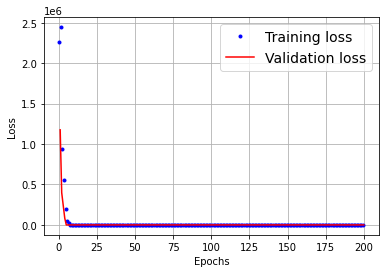

In [316]:
import matplotlib as mpl
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

2.1385458

In [318]:
yhat = model.predict(X_test, verbose=0)

results = yhat.reshape(len(y_test), int(yhat.shape[1]/X_test.shape[2]), len(transformed.columns))
for i in range(0,len(results)):
    print(pd.DataFrame(results[i])[0][0])
    print(pd.DataFrame(y_test[i])[0][0])

103.88115
1.5643749999999996
0.19471128
2.371451612903226
0.19471128
2.338888888888889
12.838856
2.1386885245901635


In [194]:
coef = pd.DataFrame(best_model.coef_).set_index(X_inter_train.columns)

a_coef = abs(coef)
a_coef.sort_values(by=[0],ascending=False,inplace=True)
chosen_few = a_coef[a_coef>0].dropna().index.values

scaler_ = preprocessing.StandardScaler().fit(transformed)

#
train_ = pd.DataFrame(scaler_.transform(transformed))
train_.columns = transformed.columns
train_.index = transformed.index  

X_inter_train_ = pd.DataFrame(interaction.fit_transform(train_.iloc[:,1:]), columns=interaction.get_feature_names(input_features=pd.DataFrame(train_.iloc[:,1:]).columns))

max_pvalue = 1
New_Names = X_inter_train.columns
X_b = X_inter_train_[chosen_few]
while (max_pvalue > .05):
        
    trf = zca.ZCA().fit(X_b)
        
    X_b_z = pd.DataFrame(trf.transform(X_b))
    X_b_z.columns=pd.DataFrame(X_b).columns
    X_b_z.index = train_.index

    model_ = sm.OLS(train_.iloc[:,0],sm.tools.tools.add_constant(X_b_z, prepend=True, has_constant='skip'))        
    #model_ = sm.OLS(pd.DataFrame(pd.concat([train_.iloc[:,0],X_b_z],axis=1),sm.tools.tools.add_constant(X_b_z, prepend=True, has_constant='skip'))        
    results_ = model_.fit()

    set_ = X_b.columns.tolist()
    
    max_pvalue = max(results_.pvalues[1:])
    if (max_pvalue > .05):
        print(max_pvalue)
        max_pname = (results_.pvalues[1:]).idxmax(axis=1)
        set_.remove(max_pname)
        New_Names = set_
    
        X_b = X_inter_train_[New_Names]
        X_b.index = X_inter_train_.index

#from statsmodels.formula.api import ols
#lm = ols(pd.DataFrame(train_.iloc[:,0]) ~ sm.tools.tools.add_constant(X_b_z, prepend=True, has_constant='skip')).fit()
#table = sm.stats.anova_lm(model_, type=3)
#print(table)
print(results_.summary())

0.7442853110844849
0.08421118739375223
                            OLS Regression Results                            
Dep. Variable:                  DGS10   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3533.
Date:                Thu, 20 May 2021   Prob (F-statistic):           8.41e-56
Time:                        19:48:38   Log-Likelihood:                 170.48
No. Observations:                  67   AIC:                            -281.0
Df Residuals:                      37   BIC:                            -214.8
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [195]:
def findNaNCols(df_):
    for col in df_:        
        num_NaNs = df_[col].isnull().sum()
        if num_NaNs > 0:
            print(f"Column: {col}")
            print(f"Number of NaNs: {num_NaNs}")

findNaNCols(X_b_z)

Summary of Regression
:                            OLS Regression Results                            
Dep. Variable:                  DGS10   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3533.
Date:                Thu, 20 May 2021   Prob (F-statistic):           8.41e-56
Time:                        19:48:51   Log-Likelihood:                 170.48
No. Observations:                  67   AIC:                            -281.0
Df Residuals:                      37   BIC:                            -214.8
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const

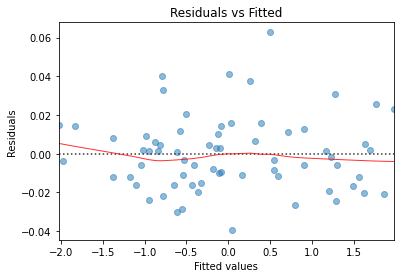

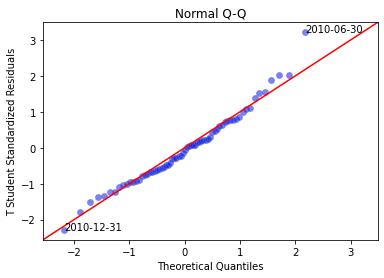

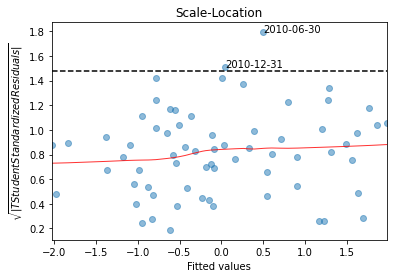

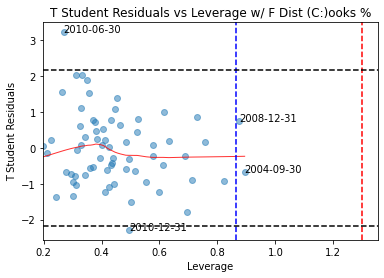

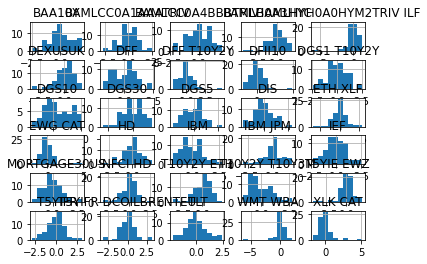

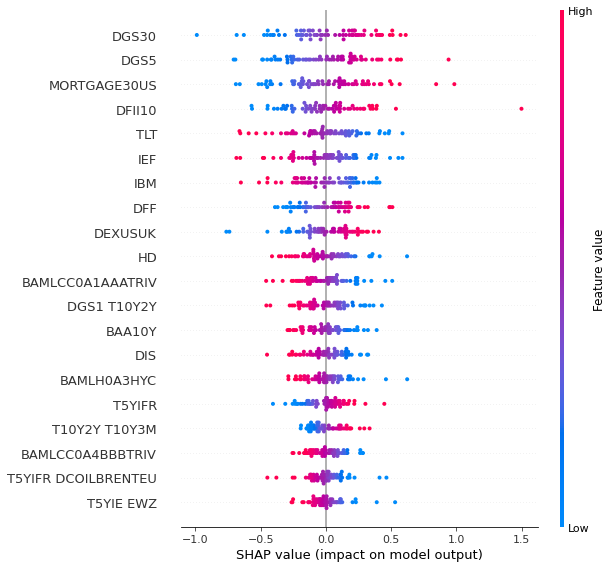

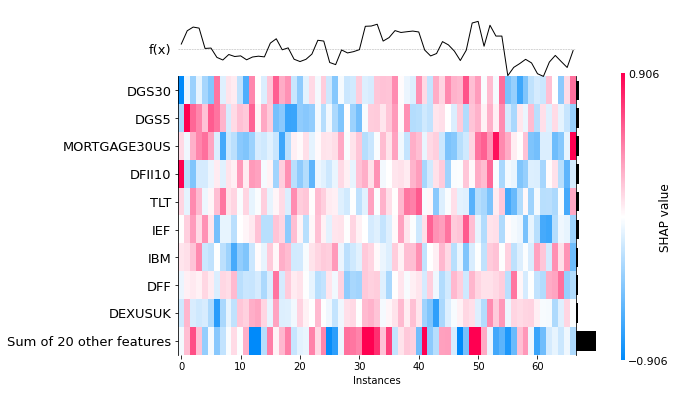

In [196]:

linear_plot = Plot.LinearRegressionResidualPlot(X_b_z, pd.DataFrame(train_.iloc[:,0]))
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))

plt.show()

%matplotlib inline

#sns.pairplot(pd.concat([pd.DataFrame(train[Y]),X_b_z],axis=1), hue=Y, height=2);

pd.concat([pd.DataFrame(train[Y]),X_b_z],axis=1).hist()

plt.show()

model_s = sklearn.linear_model.LinearRegression()
model_s.fit(X_b_z, pd.DataFrame(train_[Y]))

shap.initjs()
e = shap.explainers.Linear(model_s, X_b_z)

shap_values = e.shap_values(X_b_z)
shap.summary_plot(shap_values, X_b_z)
shap.plots.heatmap(e(X_b_z))

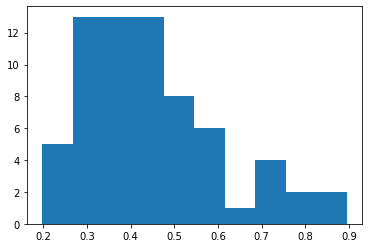

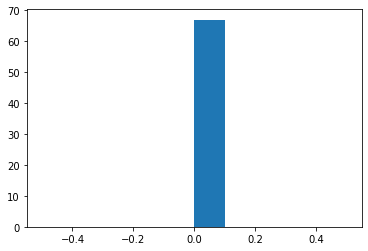

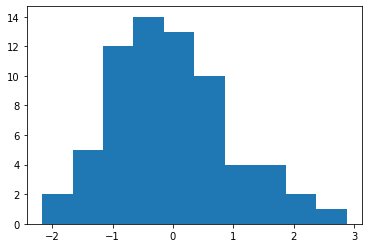

The null hypothesis cannot be rejected
Outlier threshold's
Cooks distance: > .1+
Leverage: > 0.8656716417910447 to 1.2985074626865671
Studentized residuals: > 2.1779230690821856

cooks       0.000000
leverage    0.894096
tsres      -0.681952
sres        0.008320
Name: 2004-09-30, dtype: float64

cooks       0.000000
leverage    0.875461
tsres       0.737371
sres        0.009022
Name: 2008-12-31, dtype: float64

cooks       0.000000
leverage    0.269469
tsres       2.872808
sres        0.021852
Name: 2010-06-30, dtype: float64

[66 16 30 29 28 27 26 25 24 23 22 21 20 19 18 17 15 32 14 13 12 11 10  9
  8  7  6  5  4  3  2  1 31 33 65 50 64 63 62 61 60 59 58 57 56 55 54 53
 52 51 49 34 48 47 46 45 44 43 42 41 40 39 38 37 36 35  0]
[0, 17, 23]


In [198]:
from scipy.stats import f

from statsmodels.graphics.gofplots import ProbPlot
residuals_normalized = lm.get_influence().resid_studentized_internal
cooks = lm.get_influence().cooks_distance[0]
cooks = np.round(f.pdf(cooks,len(lm.tvalues)+1, len(lm.fittedvalues)-len(lm.tvalues)-1),2)

res_std = lm.get_influence().resid_std

leverage = lm.get_influence().hat_matrix_diag

plt.hist(pd.DataFrame(leverage))
plt.show()

plt.hist(pd.DataFrame(cooks))
plt.show()

plt.hist(pd.DataFrame(residuals_normalized))
plt.show()


testNormal(residuals_normalized)

w = res_std
x = cooks
y = leverage
z = residuals_normalized

fitted_y = lm.fittedvalues

labels_ = fitted_y.index

outlier_check = pd.concat([pd.DataFrame(x),pd.DataFrame(y),pd.DataFrame(z),pd.DataFrame(w)],axis=1).set_index(labels_)

outlier_check.columns =  ['cooks', 'leverage', 'tsres', 'sres']

qq = ProbPlot(residuals_normalized)

c_thresh = .1
l_thresh = (2*(len(lm.tvalues)-1)/len(lm.fittedvalues))
s_thresh = max(qq.theoretical_quantiles)

print("Outlier threshold's")
print("Cooks distance: > .1+")
print("Leverage: > " + str(l_thresh) + " to " + str(3 * (len(lm.tvalues)-1)/len(fitted_y)))
print("Studentized residuals: > " + str(s_thresh))
print()

flag = []

for i in range(0,len(outlier_check)):
    if( (outlier_check.iloc[i][0] >= c_thresh) or (outlier_check.iloc[i][1] >= l_thresh) or (abs(outlier_check.iloc[i][2]) >= s_thresh) ):
        print(outlier_check.iloc[i])
        print()
        flag.append(True)
    else:
        flag.append(False)

outlier_check = pd.concat([outlier_check,pd.DataFrame(flag).set_index(labels_)],axis=1)

outlier_check.columns =  ['cooks', 'leverage', 'tsres', 'sres', 'flagged']

print(np.flip(np.argsort(cooks), 0))
#print(outlier_check)

search = outlier_check[outlier_check['flagged']==1].index.to_list()

rows = []

for i in search:
    v = outlier_check.index.to_list().index(i)
    rows.append(v)

print(rows)

In [199]:
def custom_style(row):

    color = 'white'
    if bool(row.flagged) == True:
        color = 'orange'

    return ['background-color: %s' % color]*len(row.values)

all_data[set(all_data.columns) & set(New_Names)]

outlier_check.style.apply(custom_style, axis=1).apply(custom_style, axis=1).background_gradient(cmap ='viridis')


TypeError: 'DataFrame' object is not callable

['DGS10', 'DGS30', 'DFII10', 'DGS5', 'MORTGAGE30US']

In [104]:
df1 = y_train.columns.to_list()
df2 = list(set(set(all_data.columns) & set(New_Names)))

flattened = [] 
for sublist in df1,df2: 
    for val in sublist: 
        flattened.append(val) 

all_data.iloc[rows][flattened].style.background_gradient(cmap ='viridis')

,DGS10,DGS30,DFII10,DGS5,MORTGAGE30US
Unnamed: 0,,,,,
2008-06-30,3.881562,4.574062,1.481719,3.155000,6.086923
2008-09-30,3.862188,4.449219,1.696406,3.112812,6.322308
2008-12-31,3.234677,3.661774,2.585161,2.172742,5.841429
2009-03-31,2.736230,3.456721,1.789016,1.761311,5.060000
2020-03-31,1.365000,1.870806,-0.063226,1.144839,3.521538
2020-06-30,0.687619,1.380794,-0.478889,0.357460,3.239231
2020-09-30,0.650625,1.362969,-0.938594,0.271719,2.952308
2020-12-31,0.864516,1.619032,-0.917097,0.369516,2.760714
2021-03-31,1.335902,2.086557,-0.849344,0.618033,2.875833
